<a href="https://colab.research.google.com/github/DeMoN-7/Deep-Learning/blob/main/Experiment-5-RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧪 Code Description: Object Detection using RCNN, Fast RCNN & Faster RCNN

This code performs object detection on a single input image using three different models: **RCNN**, **Fast RCNN**, and **Faster RCNN**, and visually compares their outputs side-by-side.

---

### 🔴 RCNN
- Uses **Selective Search** to generate region proposals.
- For each proposed region (ROI), it uses a **pretrained ResNet18** (excluding the classification layer) to extract features.
- Displays the **top 10 proposed regions** with bounding boxes in **red**.
- > ⚠️ Note: This RCNN version does not perform object classification — only region proposal + feature extraction.

---

### 🟡 Fast RCNN (Simulated)
- Since a standalone Fast RCNN model is not directly available in PyTorch, it's **simulated using Faster RCNN output**.
- Same detection boxes are used but highlighted in **yellow** to represent Fast RCNN.

---

### 🔵 Faster RCNN
- Loads a **pretrained Faster R-CNN with ResNet50-FPN** from `torchvision`.
- Detects objects directly using an **RPN (Region Proposal Network)**.
- Bounding boxes with **confidence score > 0.5** are drawn in **blue**.

---

### 📸 Visualization
- Displays the results in a **1 row × 3 columns subplot** using `matplotlib`:
  - **Left**: RCNN output (red boxes)
  - **Middle**: Fast RCNN output (yellow boxes)
  - **Right**: Faster RCNN output (blue boxes)
- Helps in visual comparison of detection performance.

---

### 🧠 Error Handling
- Handles image not found errors.
- Catches runtime exceptions such as **GPU memory errors** to prevent kernel crashes.

---


In [1]:
import cv2
import torch
import torchvision.transforms as T
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import numpy as np
import matplotlib.pyplot as plt
import warnings


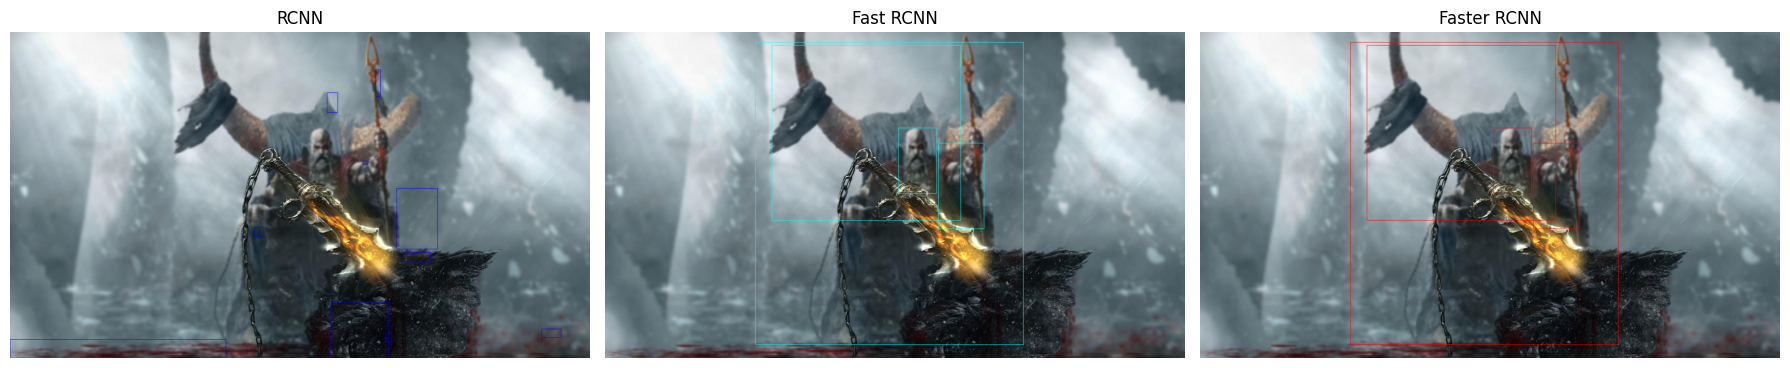

In [6]:
warnings.filterwarnings("ignore")
# ✅ Handle potential kernel crash by catching memory errors
try:
    # 📂 Load Image
    img_path = r"/content/fenrir-ragnorak-from-god-of-war.jpg"
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found at the given path.")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img_rgb.copy()

    ### 🔴 RCNN ###
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()

    resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
    resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    resnet.eval()

    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor()
    ])

    features = []
    proposals = []

    for i, (x, y, w, h) in enumerate(rects[:100]):
        roi = img_rgb[y:y+h, x:x+w]
        if roi.shape[0] < 20 or roi.shape[1] < 20:
            continue
        try:
            tensor = transform(roi).unsqueeze(0)
            with torch.no_grad():
                feat = resnet(tensor).squeeze().numpy()
            features.append(feat)
            proposals.append((x, y, w, h))
        except:
            continue

    img_rcnn = img_rgb.copy()
    for (x, y, w, h) in proposals[:10]:
        cv2.rectangle(img_rcnn, (x, y), (x + w, y + h), (0, 0, 255), 2)

    ### 🔵 Faster RCNN ###
    weights_frcnn = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    faster_rcnn = fasterrcnn_resnet50_fpn(weights=weights_frcnn)
    faster_rcnn.eval()

    transform_detect = T.Compose([T.ToTensor()])
    input_tensor = transform_detect(img_copy)

    with torch.no_grad():
        prediction_frcnn = faster_rcnn([input_tensor])

    img_faster_rcnn = img_copy.copy()
    for box, score in zip(prediction_frcnn[0]['boxes'], prediction_frcnn[0]['scores']):
        if score > 0.5:
            x1, y1, x2, y2 = [int(coord.item()) for coord in box]
            cv2.rectangle(img_faster_rcnn, (x1, y1), (x2, y2), (255, 0, 0), 2)

    ### 🟡 Fast RCNN (simulated with same boxes)
    img_fast_rcnn = img_copy.copy()
    for box, score in zip(prediction_frcnn[0]['boxes'], prediction_frcnn[0]['scores']):
        if score > 0.5:
            x1, y1, x2, y2 = [int(coord.item()) for coord in box]
            cv2.rectangle(img_fast_rcnn, (x1, y1), (x2, y2), (0, 255, 255), 2)

    ### 📊 Display results (1 row, 3 columns)
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img_rcnn)
    plt.title("RCNN")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img_fast_rcnn)
    plt.title("Fast RCNN")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img_faster_rcnn)
    plt.title("Faster RCNN")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

except RuntimeError as e:
    print("❌ Runtime error (e.g., GPU out of memory):", e)
except Exception as e:
    print("❌ Error:", e)